In [1]:
import numpy as np  
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
dataset=pd.read_csv("/content/drive/MyDrive/DATASET/SentimentAnalysis.csv",encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

In [4]:
dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
dataset.shape

(1600000, 6)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
dataset.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [8]:
dataset.count('target'==1)

target    1600000
ids       1600000
date      1600000
flag      1600000
user      1600000
text      1600000
dtype: int64

In [9]:
data=dataset[['text','target']]

In [10]:
data['target'] = data['target'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data['target'].unique()

array([0, 1])

In [12]:
grps = data.groupby(data['target'])

In [13]:
dfs=[]
for name,grp in grps:
  dfs.append(grp.sample(n=25000))


In [14]:
final_df = pd.concat(dfs)

In [15]:
final_df = final_df.sample(frac=1)

In [16]:
X = list(final_df['text'])

In [17]:
Y = list(final_df['target'])
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2
                                                    , random_state = 0)

In [18]:
train_text = x_train
train_labels = y_train

In [19]:

val_text, test_text, val_labels, test_labels = train_test_split(x_test,y_test,test_size=0.5)

In [20]:
print(len(train_text),len(val_text),len(test_text))

40000 5000 5000


In [21]:
!pip install transformers

In [22]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel,RobertaTokenizerFast

In [23]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('roberta-base')

# Load the BERT tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


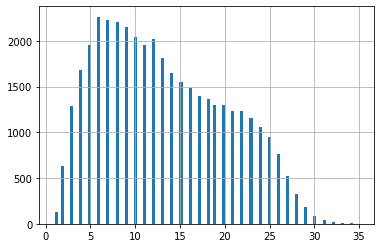

In [24]:
seq_len = [len(i.split()) for i in train_text ]

pd.Series(seq_len).hist(bins = 100)

In [25]:
max_seq_len = 55

In [26]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [29]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [30]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # relu activation function
      self.relu =  nn.ReLU()

      # BI-LSTM
      self.Lstm = nn.LSTM(input_size=768,hidden_size=128,num_layers = 2,dropout = 0.3,bidirectional = True)
      self.bn_256 = nn.BatchNorm1d(256)
      # dense layer 1
      self.fc1 = nn.Linear(256,64)
      self.bn1 = nn.BatchNorm1d(64)
      # dense layer 2 (Output layer)
   
      self.fc2 = nn.Linear(64,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
      

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      p = self.bert(sent_id, attention_mask=mask)

      # lstm forward prop
      x_lstm = self.Lstm(p[0])
      x_lstm = x_lstm[0].sum(axis = 1)
      x_lstm = self.bn_256(x_lstm)
      x = self.relu(x_lstm)

      #fully connected layer forward prop
      x = self.fc1(x)
      x = self.bn1(x)
      x = self.relu(x)

      # apply softmax activation
      x = self.softmax(self.fc2(x))

      return x

In [31]:
device = torch.device('cuda')

In [32]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
#path="/content/gdrive/MyDrive/saved_weights_acc.pt"
#model.load_state_dict(torch.load(path))
# push the model to GPU
model = model.to(device)

In [33]:
for i in train_dataloader:
  break

In [34]:
y =bert(i[0].to('cuda'),attention_mask=i[1].to('cuda'))

In [35]:
j = y[0].sum(axis =1)

In [36]:
j.shape

torch.Size([32, 768])

In [37]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 4e-3)
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.05)

cross_entropy = nn.CrossEntropyLoss()

In [38]:
epochs = 10

In [39]:
from sklearn.metrics import accuracy_score

def accuracy(scores, targets):
    y_prediction = []
    for p in scores:

        y_prediction.append(p.argmax().item())
    y_true = np.array(targets.to('cpu'))

    targets.to(device)
    return accuracy_score(y_true, np.array(y_prediction))

In [40]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  epoch_acc = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 750 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    #accuracy
    epoch_acc = epoch_acc + accuracy(preds,labels)

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds , epoch_acc/len(train_dataloader)

In [41]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  epoch_acc = 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed =(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      epoch_acc = epoch_acc + accuracy(preds,labels)

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds,epoch_acc/len(val_dataloader)

In [42]:
# set initial loss to infinite
prev_acc = 0
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch

train_losses=[]
valid_losses=[]
accuracy_train = []
accuracy_test = []


import time
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    start_time = time.time()
    #train model
    train_loss, train_predictions,train_acc = train()
    
    #evaluate model
    valid_loss, test_predictions,test_acc = evaluate()
    
    print(f'\ntime taken for epoch :{time.time()/60-start_time/60}')
    #save the best model
    if test_acc > prev_acc:
        torch.save(model.state_dict(), '/content/drive/MyDrive/saved_weights_acc_last.pt')
    prev_acc = test_acc

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/saved_weights_loss_last.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    accuracy_train.append(train_acc)
    accuracy_test.append(test_acc)
    
    print(f'\nTraining Loss: {train_loss:.3f} || {train_acc:.3f}')
    print(f'Validation Loss: {valid_loss:.3f} || {test_acc:.3f}')


 Epoch 1 / 10
  Batch   750  of  1,250.

Evaluating...
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

time taken for epoch :5.515872165560722

Training Loss: 0.479 || 0.772
Validation Loss: 0.429 || 0.805

 Epoch 2 / 10
  Batch   750  of  1,250.

Evaluating...
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

time taken for epoch :5.497102797031403

Training Loss: 0.431 || 0.804
Validation Loss: 0.405 || 0.831

 Epoch 3 / 10
  Batch   750  of  1,250.

Evaluating...
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

time taken for epoch :5.471276171505451

Training Loss: 0.414 || 0.812
Validation Loss: 0.387 || 0.829

 Epoch 4 / 10
  Batch   750  of  1,250.

Evaluating...
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

time taken for epoch :5.521217279136181

Training Loss: 0.408 || 0.814
Validation Loss: 0.382 || 0.842

 Epoch 5 / 10
  Batch   750  of  1,250.

Evalua

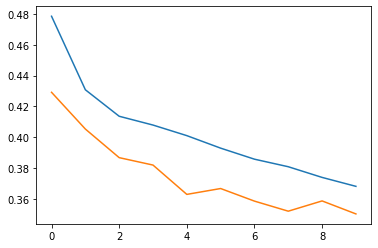

In [43]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

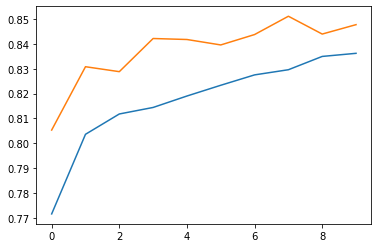

In [44]:
plt.plot(accuracy_train)
plt.plot(accuracy_test)

In [45]:
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [46]:
def evaluate(test_dataloader):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  epoch_acc = 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 100 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed =(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      epoch_acc = epoch_acc + accuracy(preds,labels)
      #print(epoch_acc)

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds,epoch_acc/len(test_dataloader)

In [47]:
test_preds = evaluate(test_dataloader)


Evaluating...
  Batch   100  of    157.


In [ ]:
test_preds[2]

In [50]:
def raw_data_tester(text):
  raw_text = tokenizer.batch_encode_plus(
    text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )
  sent = torch.tensor(raw_text['input_ids'])
  mask = torch.tensor(raw_text['attention_mask'])
  with torch.no_grad():
    model.eval()
    pred  = model(sent.to(device),mask.to(device))

  return pred.argmax(1)

In [54]:
import os
import tweepy as tw
import pandas as pd

In [55]:
consumer_key= 'mBoYjtxttekt7nA3oa564nl4J'
consumer_secret= 'UUl6zhaDsSnf3OYvLJsqGitR0nbl0cuzhFpDLoMF8L88dBlJFr'
access_token= '1435952824043532295-E2sbl3E0QhOVNQetKmyJ1WpgIWmFIC'
access_token_secret= 'vN9AkN7kuiGpwKyzv1rSTVWWqbzYYkMD2S9nUXF4rSZgO'

In [56]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [57]:

search_words = "#politics"

In [63]:
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",).items(100)

In [ ]:
df.to_csv(r'c:\data\pandas1.txt',header=None, index=None, sep=' ', mode='a')
with open('/content/c:\data\pandas1.txt') as f:
  text=f.read().splitlines()
test_preds=raw_data_tester(text)
print(test_preds)
res=[]
for i in test_preds:
  res.append(i.item())
print(res)

In [ ]:
import matplotlib.pyplot as plt
zeroes=res.count(0)
ones=res.count(1)
height=[zeroes,ones]
left=[0,1]
tick_label=["negative", "positive"]
plt.bar(left,height,tick_label=tick_label, width=0.8, color=['red','green'])

In [ ]:
search_words = "#health"
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",).items(100)
val=[tweet.text for tweet in tweets]
df = pd.DataFrame(val)
df.head()
df.columns = ['Tweets']
df.head()
df.to_csv(r'c:\data\pandas2.txt',header=None, index=None, sep=' ', mode='a')
with open('/content/c:\data\pandas2.txt') as f:
  text=f.read().splitlines()
test_preds=raw_data_tester(text)
print(test_preds)
res=[]
for i in test_preds:
  res.append(i.item())
print(res)
import matplotlib.pyplot as plt
zeroes=res.count(0)
ones=res.count(1)
height=[zeroes,ones]
left=[0,1]
tick_label=["negative", "positive"]
plt.bar(left,height,tick_label=tick_label, width=0.8, color=['red','green'])

In [ ]:
search_words = "#globalwarming"
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",).items(100)
val=[tweet.text for tweet in tweets]
df = pd.DataFrame(val)
df.head()
df.columns = ['Tweets']
df.head()
df.to_csv(r'c:\data\pandas3.txt',header=None, index=None, sep=' ', mode='a')
with open('/content/c:\data\pandas3.txt') as f:
  text=f.read().splitlines()
test_preds=raw_data_tester(text)
print(test_preds)
res=[]
for i in test_preds:
  res.append(i.item())
print(res)
import matplotlib.pyplot as plt
zeroes=res.count(0)
ones=res.count(1)
height=[zeroes,ones]
left=[0,1]
tick_label=["negative", "positive"]
plt.bar(left,height,tick_label=tick_label, width=0.8, color=['red','green'])

In [ ]:
search_words = "#socialmedia"
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",).items(100)
val=[tweet.text for tweet in tweets]
df = pd.DataFrame(val)
df.head()
df.columns = ['Tweets']
df.head()
df.to_csv(r'c:\data\pandas1.txt',header=None, index=None, sep=' ', mode='a')
with open('/content/c:\data\pandas1.txt') as f:
  text=f.read().splitlines()
test_preds=raw_data_tester(text)
print(test_preds)
res=[]
for i in test_preds:
  res.append(i.item())
print(res)
import matplotlib.pyplot as plt
zeroes=res.count(0)
ones=res.count(1)
height=[zeroes,ones]
left=[0,1]
tick_label=["negative", "positive"]
plt.bar(left,height,tick_label=tick_label, width=0.8, color=['red','green'])